In [1]:
import requests
import pandas as pd

# URL directa de la API
url = "https://api.weball.me/public/tournament/176/phase/150/group/613/clasification?instanceUUID=2d260df1-7986-49fd-95a2-fcb046e7a4fb"

# Hacer request a la API
response = requests.get(url)
data = response.json()

# Acceder a la lista de posiciones
positions = data[1]['positions']

# Extraer los datos relevantes
equipos = []
for equipo in positions:
    nombre = equipo['labelTablePosition']['name']
    pts = equipo['pts']
    pj = equipo['pj']
    pg = equipo['pg']
    pe = equipo['pe']
    pp = equipo['pp']
    gf = equipo['gf']
    gc = equipo['gc']
    dg = equipo['dg']
    equipos.append({
        'Equipo': nombre,
        'Pts': pts,
        'PJ': pj,
        'PG': pg,
        'PE': pe,
        'PP': pp,
        'GF': gf,
        'GC': gc,
        'DG': dg
    })

# Crear DataFrame
df_tabla = pd.DataFrame(equipos)

# Mostrar tabla
df_tabla.sort_values(by='Pts', ascending=False).reset_index(drop=True)


,Equipo,Pts,PJ,PG,PE,PP,GF,GC,DG
0,17 DE AGOSTO,38,14,12,2,0,61,21,40
1,KIMBERLEY,36,14,11,3,0,44,11,33
2,SAN LORENZO,32,14,10,2,2,55,20,35
3,MIRIÑAQUE,31,14,9,4,1,53,20,33
4,RIVER PLATE,29,14,9,2,3,60,27,33
5,CISSAB,24,14,7,3,4,42,27,15
6,VILLA MODELO,19,14,6,1,7,39,44,-5
7,BOCA JUNIORS,18,14,6,0,8,35,44,-9
8,PINOCHO,17,14,5,2,7,36,51,-15
9,VELEZ SARSFIELD,16,14,5,1,8,34,36,-2


In [2]:
import requests
import pandas as pd

url = "https://api.weball.me/public/tournament/176/phase/150/matches?instanceUUID=2d260df1-7986-49fd-95a2-fcb046e7a4fb"
headers = {"Content-Type": "application/json"}

response = requests.post(url, headers=headers, json={})
data = response.json()
total_pages = data.get("totalPages", 1)

partidos = []

for page in range(1, total_pages + 1):
    payload = {"page": page}
    res = requests.post(url, headers=headers, json=payload)
    page_data = res.json().get("data", [])

    for match in page_data:
        categoria = match.get("category", {}).get("categoryInstance", {}).get("name", "")
        if "2016 PROMOCIONALES" not in categoria:
            continue

        try:
            local = match['clubHome']['clubInscription']['club']['name']
            visitante = match['clubAway']['clubInscription']['club']['name']
        except:
            local = "LIBRE"
            visitante = ""

        goles_local = match.get("scoreHome")
        goles_visitante = match.get("scoreAway")
        status = match.get("status")
        estado = status.get("label") if isinstance(status, dict) else "Desconocido"

        # Usamos containerItemsId para la jornada
        contenedor = match.get("containerItemsId", [])
        jornada_id = contenedor[0] if contenedor else None

        fecha_tecnica = match.get("updatedAt") or match.get("createdAt")

        partidos.append({
            "Fecha Técnica": fecha_tecnica,
            "Jornada ID": jornada_id,
            "Estado": estado,
            "Equipo Local": local,
            "Equipo Visitante": visitante,
            "Goles Local": goles_local,
            "Goles Visitante": goles_visitante
        })

# Crear DataFrame
df_partidos = pd.DataFrame(partidos)

# Mapear los IDs de jornada a una secuencia ordenada: Fecha 1, Fecha 2, ...
ids_ordenados = sorted(df_partidos["Jornada ID"].dropna().unique())
mapa_fechas = {jid: f"Fecha {i+1}" for i, jid in enumerate(ids_ordenados)}
# Solo asignar la jornada (Fecha N) a los partidos jugados
df_partidos["Fecha"] = None
df_partidos.loc[df_partidos["Estado"].str.lower() == "finalizado", "Fecha"] = \
    df_partidos.loc[df_partidos["Estado"].str.lower() == "finalizado", "Jornada ID"].map(mapa_fechas)


# Dividir en resultados y fixture
df_resultados = df_partidos[df_partidos["Estado"].str.lower() == "finalizado"]
df_fixture = df_partidos[~df_partidos["Estado"].str.lower().isin(["finalizado", "cancelado"])]

# Vista previa
print("📊 Resultados jugados:")
display(df_resultados)

print("📆 Próximos partidos:")
display(df_fixture)


📊 Resultados jugados:


,Fecha Técnica,Jornada ID,Estado,Equipo Local,Equipo Visitante,Goles Local,Goles Visitante,Fecha
0,2025-03-24T16:22:19.060Z,1007,Finalizado,VELEZ SARSFIELD,KIMBERLEY,1.0,6.0,Fecha 1
1,2025-03-24T14:37:10.849Z,1007,Finalizado,FRANJA DE ORO,INDEPENDIENTE (A),3.0,0.0,Fecha 1
2,2025-03-24T14:23:16.833Z,1007,Finalizado,FERRO CARRIL OESTE,CISSAB,2.0,2.0,Fecha 1
3,2025-03-25T15:42:16.038Z,1007,Finalizado,PINOCHO,BOCA JUNIORS,5.0,4.0,Fecha 1
4,2025-04-18T18:25:00.808Z,1007,Finalizado,MIRIÑAQUE,RIVER PLATE,3.0,3.0,Fecha 1
...,...,...,...,...,...,...,...,...
115,2025-07-07T13:04:58.273Z,1021,Finalizado,VILLA MODELO,MIRIÑAQUE,2.0,3.0,Fecha 15
116,2025-07-07T14:53:21.358Z,1021,Finalizado,RIVER PLATE,PINOCHO,9.0,0.0,Fecha 15
117,2025-07-07T12:45:01.432Z,1021,Finalizado,BOCA JUNIORS,FERRO CARRIL OESTE,4.0,1.0,Fecha 15
118,2025-07-07T17:46:57.821Z,1021,Finalizado,CISSAB,FRANJA DE ORO,3.0,3.0,Fecha 15


📆 Próximos partidos:


,Fecha Técnica,Jornada ID,Estado,Equipo Local,Equipo Visitante,Goles Local,Goles Visitante,Fecha
5,2025-03-28T18:08:44.579Z,1007,NO PRESENTACIÓN,UNION EZPELETA,VILLA MODELO,0.0,5.0,None
7,2025-05-16T15:57:39.160Z,1007,Finalizado Libre / NP AMBOS,LIBRE,,NaN,NaN,None
9,2025-05-16T17:12:50.972Z,1008,Finalizado Libre / NP AMBOS,LIBRE,,NaN,NaN,None
22,2025-05-16T17:23:48.151Z,1009,Finalizado Libre / NP AMBOS,LIBRE,,NaN,NaN,None
26,2025-05-16T17:34:08.273Z,1010,Finalizado Libre / NP AMBOS,LIBRE,,NaN,NaN,None
33,2025-05-20T22:54:57.440Z,1011,Fallo de Tribunal,PINOCHO,FRANJA DE ORO,5.0,0.0,None
37,2025-05-16T17:48:53.568Z,1011,Finalizado Libre / NP AMBOS,LIBRE,,NaN,NaN,None
43,2025-05-20T18:36:52.440Z,1012,Finalizado Libre / NP AMBOS,LIBRE,,NaN,NaN,None
52,2025-05-16T17:56:25.782Z,1013,Finalizado Libre / NP AMBOS,LIBRE,,NaN,NaN,None
60,2025-05-16T18:06:22.322Z,1014,Finalizado Libre / NP AMBOS,LIBRE,,NaN,NaN,None


In [3]:
import pandas as pd

# Asegurar formato de fechas
df_resultados["Fecha Técnica"] = pd.to_datetime(df_resultados["Fecha Técnica"])

# Ordenar partidos jugados
df_resultados_ordenado = df_resultados.sort_values("Fecha Técnica").reset_index(drop=True)

# Inicializar acumuladores
tabla_historica = []
equipos = pd.Series(df_resultados_ordenado["Equipo Local"].tolist() + df_resultados_ordenado["Equipo Visitante"].tolist()).unique()

# Diccionarios de stats iniciales
stats = {equipo: {"Pts": 0, "PJ": 0, "PG": 0, "PE": 0, "PP": 0, "GF": 0, "GC": 0} for equipo in equipos}

# Procesar partido por partido
for _, row in df_resultados_ordenado.iterrows():
    fecha = row["Fecha Técnica"]
    local = row["Equipo Local"]
    visitante = row["Equipo Visitante"]
    gl = row["Goles Local"]
    gv = row["Goles Visitante"]

    # Actualizar PJ
    stats[local]["PJ"] += 1
    stats[visitante]["PJ"] += 1

    # Actualizar goles
    stats[local]["GF"] += gl
    stats[local]["GC"] += gv
    stats[visitante]["GF"] += gv
    stats[visitante]["GC"] += gl

    # Actualizar puntos
    if gl > gv:
        stats[local]["Pts"] += 3
        stats[local]["PG"] += 1
        stats[visitante]["PP"] += 1
    elif gl < gv:
        stats[visitante]["Pts"] += 3
        stats[visitante]["PG"] += 1
        stats[local]["PP"] += 1
    else:
        stats[local]["Pts"] += 1
        stats[visitante]["Pts"] += 1
        stats[local]["PE"] += 1
        stats[visitante]["PE"] += 1

    # Generar tabla snapshot
    tabla_fecha = []
    for equipo in equipos:
        tabla_fecha.append({
            "Fecha Técnica": fecha,
            "Equipo": equipo,
            "Pts": stats[equipo]["Pts"],
            "PJ": stats[equipo]["PJ"],
            "PG": stats[equipo]["PG"],
            "PE": stats[equipo]["PE"],
            "PP": stats[equipo]["PP"],
            "GF": stats[equipo]["GF"],
            "GC": stats[equipo]["GC"],
            "DG": stats[equipo]["GF"] - stats[equipo]["GC"]
        })
    tabla_fecha_df = pd.DataFrame(tabla_fecha)
    tabla_fecha_df = tabla_fecha_df.sort_values(["Pts", "DG", "GF"], ascending=[False, False, False]).reset_index(drop=True)
    tabla_fecha_df["Posición"] = tabla_fecha_df.index + 1

    tabla_historica.append(tabla_fecha_df)

# Unificar todo en un único DataFrame
df_tabla_evolutiva = pd.concat(tabla_historica).reset_index(drop=True)

# Resultado final
df_tabla_evolutiva


/tmp/ipython-input-1987747849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados["Fecha Técnica"] = pd.to_datetime(df_resultados["Fecha Técnica"])


,Fecha Técnica,Equipo,Pts,PJ,PG,PE,PP,GF,GC,DG,Posición
0,2025-03-24 14:23:16.833000+00:00,FERRO CARRIL OESTE,1,1,0,1,0,2.0,2.0,0.0,1
1,2025-03-24 14:23:16.833000+00:00,CISSAB,1,1,0,1,0,2.0,2.0,0.0,2
2,2025-03-24 14:23:16.833000+00:00,FRANJA DE ORO,0,0,0,0,0,0.0,0.0,0.0,3
3,2025-03-24 14:23:16.833000+00:00,SAN LORENZO,0,0,0,0,0,0.0,0.0,0.0,4
4,2025-03-24 14:23:16.833000+00:00,VELEZ SARSFIELD,0,0,0,0,0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...
1495,2025-07-07 17:46:57.821000+00:00,PINOCHO,14,13,4,2,7,31.0,51.0,-20.0,11
1496,2025-07-07 17:46:57.821000+00:00,FRANJA DE ORO,8,12,2,2,8,23.0,32.0,-9.0,12
1497,2025-07-07 17:46:57.821000+00:00,INDEPENDIENTE (A),8,13,2,2,9,28.0,49.0,-21.0,13
1498,2025-07-07 17:46:57.821000+00:00,SOCIEDAD HEBRAICA,3,11,1,0,10,5.0,65.0,-60.0,14


In [4]:
import numpy as np
import pandas as pd

# ✅ Limpieza del DataFrame original
df_resultados_clean = df_resultados[
    (df_resultados["Equipo Local"].notnull()) &
    (df_resultados["Equipo Visitante"].notnull()) &
    (df_resultados["Equipo Local"].str.upper() != "LIBRE") &
    (df_resultados["Equipo Visitante"].str.upper() != "LIBRE")
].copy()

# ✅ Usamos la fecha técnica (orden cronológico de partidos jugados)
df_resultados_clean["Fecha Técnica"] = pd.to_datetime(df_resultados_clean["Fecha Técnica"])
df_resultados_clean = df_resultados_clean.sort_values("Fecha Técnica")
df_resultados_clean["Jornada"] = df_resultados_clean["Fecha"]

# ⚙️ Parámetros ELO
K = 40
indice_inicial = 1000
bonus_localia_fifa = 100

# 🧾 Inicializar índices
equipos = pd.Series(df_resultados_clean["Equipo Local"].tolist() + df_resultados_clean["Equipo Visitante"].tolist()).unique()
indices_actuales = {equipo: indice_inicial for equipo in equipos}
evolucion = []

# 🔁 Cálculo del índice fecha a fecha
for fecha_tecnica in df_resultados_clean["Fecha Técnica"].unique():
    partidos = df_resultados_clean[df_resultados_clean["Fecha Técnica"] == fecha_tecnica]
    for _, row in partidos.iterrows():
        local = row["Equipo Local"]
        visitante = row["Equipo Visitante"]
        gl = row["Goles Local"]
        gv = row["Goles Visitante"]
        jornada = row["Jornada"]

        idx_local = indices_actuales[local]
        idx_vis = indices_actuales[visitante]

        # Resultado real
        if gl > gv:
            r_local, r_vis = 1, 0
        elif gl < gv:
            r_local, r_vis = 0, 1
        else:
            r_local = r_vis = 0.5

        # Resultado esperado con ventaja de localía
        e_local = 1 / (1 + 10 ** ((idx_vis - idx_local + bonus_localia_fifa) / 400))
        e_vis = 1 / (1 + 10 ** ((idx_local - idx_vis - bonus_localia_fifa) / 400))

        adj_local = K * (r_local - e_local)
        adj_vis = K * (r_vis - e_vis)

        dg = abs(gl - gv)
        mult = 1 + (dg / 4)

        max_idx = max(indices_actuales.values())
        ofensivo_local = (gl / (1 + gv)) * (idx_vis / max_idx)
        defensivo_local = (gv / (1 + gl)) * (1 - idx_vis / max_idx)
        ofensivo_vis = (gv / (1 + gl)) * (idx_local / max_idx)
        defensivo_vis = (gl / (1 + gv)) * (1 - idx_local / max_idx)

        total_local = (adj_local * mult) + ofensivo_local - defensivo_local
        total_vis = (adj_vis * mult) + ofensivo_vis - defensivo_vis

        indices_actuales[local] += total_local
        indices_actuales[visitante] += total_vis

    for equipo in equipos:
        evolucion.append({
            "Fecha Técnica": fecha_tecnica,
            "Jornada": jornada,
            "Equipo": equipo,
            "Indice": round(indices_actuales[equipo], 2)
        })

df_evo = pd.DataFrame(evolucion).sort_values(["Equipo", "Fecha Técnica"]).reset_index(drop=True)

# ➕ Resultado real
resultados_reales = []
for _, row in df_resultados_clean.iterrows():
    jornada = row["Jornada"]
    fecha = row["Fecha Técnica"]
    local = row["Equipo Local"]
    visitante = row["Equipo Visitante"]
    gl = row["Goles Local"]
    gv = row["Goles Visitante"]
    if gl > gv:
        resultados_reales.append((fecha, jornada, local, "G"))
        resultados_reales.append((fecha, jornada, visitante, "P"))
    elif gl < gv:
        resultados_reales.append((fecha, jornada, local, "P"))
        resultados_reales.append((fecha, jornada, visitante, "G"))
    else:
        resultados_reales.append((fecha, jornada, local, "E"))
        resultados_reales.append((fecha, jornada, visitante, "E"))

df_resultados_equipo = pd.DataFrame(resultados_reales, columns=["Fecha Técnica", "Jornada", "Equipo", "Resultado"])
df_evo = df_evo.merge(df_resultados_equipo, on=["Fecha Técnica", "Jornada", "Equipo"], how="left")

# ✅ Calcular Delta
df_evo["Delta"] = 0.0
for equipo in df_evo["Equipo"].unique():
    df_eq = df_evo[df_evo["Equipo"] == equipo].copy().sort_values("Fecha Técnica")
    indices = df_eq["Indice"].tolist()
    deltas = [indices[i] - 1000 if i == 0 else indices[i] - indices[i - 1] for i in range(len(indices))]
    df_evo.loc[df_evo["Equipo"] == equipo, "Delta"] = deltas

# 🎯 Filtrar fechas jugadas
df_evo_filtrada = df_evo[~df_evo["Resultado"].isna()].copy()

# 🔁 Tendencia + Racha
def calcular_tendencia_3_ultimos(deltas):
    if len(deltas) < 3:
        return "→ Estable"
    promedio = np.mean(deltas[-3:])
    if promedio > 3:
        return "↗️ Alza"
    elif promedio < -3:
        return "↘️ Baja"
    else:
        return "→ Estable"

tendencias_avanzadas = []
for equipo, grupo in df_evo_filtrada.groupby("Equipo"):
    grupo = grupo.sort_values("Fecha Técnica").copy()
    deltas = grupo["Delta"].tolist()
    indices = grupo["Indice"].tolist()
    jornadas = grupo["Jornada"].tolist()
    fechas = grupo["Fecha Técnica"].tolist()
    resultados = grupo["Resultado"].tolist()

    tendencias_3 = [calcular_tendencia_3_ultimos(deltas[:i+1]) for i in range(len(deltas))]

    rachas = []
    actual = resultados[0]
    cuenta = 1
    rachas.append(f"{actual}({cuenta})")
    for i in range(1, len(resultados)):
        if resultados[i] == resultados[i-1]:
            cuenta += 1
        else:
            cuenta = 1
        rachas.append(f"{resultados[i]}({cuenta})")

    for ftec, j, e, i, d, t3, r in zip(fechas, jornadas, [equipo]*len(jornadas), indices, deltas, tendencias_3, rachas):
        tendencias_avanzadas.append({
            "Fecha Técnica": ftec,
            "Jornada": j,
            "Equipo": e,
            "Indice": round(i, 2),
            "Delta": round(d, 2),
            "Tendencia (últ 3)": t3,
            "Racha": r
        })

# ✅ Continuación después del armado de df_elo_evolucion

# 📦 Resultado final
df_elo_evolucion = pd.DataFrame(tendencias_avanzadas)
df_elo_evolucion = df_elo_evolucion.sort_values(["Equipo", "Fecha Técnica"]).reset_index(drop=True)

# Inicializar PJ por equipo
pj_por_equipo = {}

partidos_jugados = []

for idx, row in df_elo_evolucion.iterrows():
    equipo = row["Equipo"]
    if equipo not in pj_por_equipo:
        pj_por_equipo[equipo] = 1
    else:
        pj_por_equipo[equipo] += 1
    partidos_jugados.append(pj_por_equipo[equipo])

# Asignar al DataFrame
df_elo_evolucion["PJ"] = partidos_jugados

# Mostramos el DataFrame final
df_elo_evolucion

,Fecha Técnica,Jornada,Equipo,Indice,Delta,Tendencia (últ 3),Racha,PJ
0,2025-03-31 14:49:41.318000+00:00,Fecha 2,17 DE AGOSTO,1030.66,30.66,→ Estable,G(1),1
1,2025-04-07 15:20:36.518000+00:00,Fecha 3,17 DE AGOSTO,1086.46,55.80,→ Estable,G(2),2
2,2025-04-14 14:05:30.030000+00:00,Fecha 4,17 DE AGOSTO,1113.55,27.09,↗️ Alza,G(3),3
3,2025-04-19 22:48:21.397000+00:00,Fecha 5,17 DE AGOSTO,1140.43,26.88,↗️ Alza,G(4),4
4,2025-04-28 18:29:56.178000+00:00,Fecha 6,17 DE AGOSTO,1155.33,14.90,↗️ Alza,G(5),5
...,...,...,...,...,...,...,...,...
195,2025-06-01 20:31:56.590000+00:00,Fecha 11,VILLA MODELO,987.44,-17.68,↘️ Baja,P(1),9
196,2025-06-07 22:56:15.512000+00:00,Fecha 12,VILLA MODELO,1006.44,19.00,↗️ Alza,G(1),10
197,2025-06-18 15:35:49.314000+00:00,Fecha 13,VILLA MODELO,1046.30,39.86,↗️ Alza,G(2),11
198,2025-06-30 14:14:48.242000+00:00,Fecha 14,VILLA MODELO,990.55,-55.75,→ Estable,P(1),12


In [5]:
import pandas as pd

# Tomamos el último índice por equipo
ultimo_elo = df_elo_evolucion.sort_values("Fecha Técnica").groupby("Equipo").last().reset_index()

# Ordenamos de mayor a menor
ultimo_elo_ordenado = ultimo_elo.sort_values("Indice", ascending=False).reset_index(drop=True)

ultimo_elo_ordenado


,Equipo,Fecha Técnica,Jornada,Indice,Delta,Tendencia (últ 3),Racha,PJ
0,17 DE AGOSTO,2025-07-07 12:42:14.807000+00:00,Fecha 15,1309.02,30.57,↗️ Alza,G(6),14
1,KIMBERLEY,2025-07-07 17:00:30.604000+00:00,Fecha 15,1245.86,5.13,↗️ Alza,G(4),13
2,SAN LORENZO,2025-07-07 12:42:14.807000+00:00,Fecha 15,1214.20,-29.11,↗️ Alza,P(1),14
3,RIVER PLATE,2025-07-07 14:53:21.358000+00:00,Fecha 15,1198.28,59.44,↗️ Alza,G(3),14
4,MIRIÑAQUE,2025-07-07 13:04:58.273000+00:00,Fecha 15,1161.19,9.74,↘️ Baja,G(2),14
5,CISSAB,2025-07-07 17:46:57.821000+00:00,Fecha 15,1081.64,-2.30,↘️ Baja,E(1),14
6,BOCA JUNIORS,2025-07-07 12:45:01.432000+00:00,Fecha 15,985.70,44.59,↘️ Baja,G(1),14
7,VILLA MODELO,2025-07-07 13:04:58.273000+00:00,Fecha 15,981.76,-8.79,↘️ Baja,P(2),13
8,FRANJA DE ORO,2025-07-07 17:46:57.821000+00:00,Fecha 15,941.20,3.12,↗️ Alza,E(1),12
9,VELEZ SARSFIELD,2025-06-30 19:22:08.130000+00:00,Fecha 14,940.71,-39.01,↘️ Baja,P(3),14


In [6]:
# ✅ Último registro de cada equipo
ultimo = df_elo_evolucion.sort_values("Fecha Técnica").groupby("Equipo").last().reset_index()

# ✅ Agrupamos equipos por tendencia
tendencias = {
    "↗️ Alza": ultimo[ultimo["Tendencia (últ 3)"] == "↗️ Alza"]["Equipo"].tolist(),
    "→ Estable": ultimo[ultimo["Tendencia (últ 3)"] == "→ Estable"]["Equipo"].tolist(),
    "↘️ Baja": ultimo[ultimo["Tendencia (últ 3)"] == "↘️ Baja"]["Equipo"].tolist()
}

# ✅ Convertimos en DataFrame tipo tabla por columnas
max_len = max(len(lst) for lst in tendencias.values())
tabla_tendencia = pd.DataFrame({
    "↗️ Alza": tendencias["↗️ Alza"] + [""] * (max_len - len(tendencias["↗️ Alza"])),
    "→ Estable": tendencias["→ Estable"] + [""] * (max_len - len(tendencias["→ Estable"])),
    "↘️ Baja": tendencias["↘️ Baja"] + [""] * (max_len - len(tendencias["↘️ Baja"]))
})

tabla_tendencia


,↗️ Alza,→ Estable,↘️ Baja
0,17 DE AGOSTO,,BOCA JUNIORS
1,FRANJA DE ORO,,CISSAB
2,INDEPENDIENTE (A),,FERRO CARRIL OESTE
3,KIMBERLEY,,MIRIÑAQUE
4,RIVER PLATE,,PINOCHO
5,SAN LORENZO,,UNION EZPELETA
6,SOCIEDAD HEBRAICA,,VELEZ SARSFIELD
7,,,VILLA MODELO


In [8]:
import pandas as pd

# ✅ Último registro por equipo
ultimo_elo = df_elo_evolucion.sort_values("Fecha Técnica").groupby("Equipo").last().reset_index()

# ✅ Agrupar por tendencia
grupos = {
    "↗️ Alza": [],
    "→ Estable": [],
    "↘️ Baja": []
}

for _, row in ultimo_elo.iterrows():
    grupos[row["Tendencia (últ 3)"]].append({
        "Equipo": row["Equipo"],
        "Racha": row["Racha"],
        "Indice": round(row["Indice"], 2)
    })

# ✅ Crear y ordenar DataFrames individuales por ELO descendente
df_alza = pd.DataFrame(grupos["↗️ Alza"]).sort_values("Indice", ascending=False).reset_index(drop=True)
df_estable = pd.DataFrame(grupos["→ Estable"]).sort_values("Indice", ascending=False).reset_index(drop=True)
df_baja = pd.DataFrame(grupos["↘️ Baja"]).sort_values("Indice", ascending=False).reset_index(drop=True)

# ✅ Renombrar columnas para tabla final
tabla_ranking = pd.concat([
    df_alza.rename(columns={"Equipo": "ALZA", "Racha": "Racha Alza", "Indice": "ELO Alza"}),
    df_estable.rename(columns={"Equipo": "ESTABLE", "Racha": "Racha Estable", "Indice": "ELO Estable"}),
    df_baja.rename(columns={"Equipo": "BAJA", "Racha": "Racha Baja", "Indice": "ELO Baja"})
], axis=1)

# Mostrar tabla
tabla_ranking


KeyError: 'Indice'

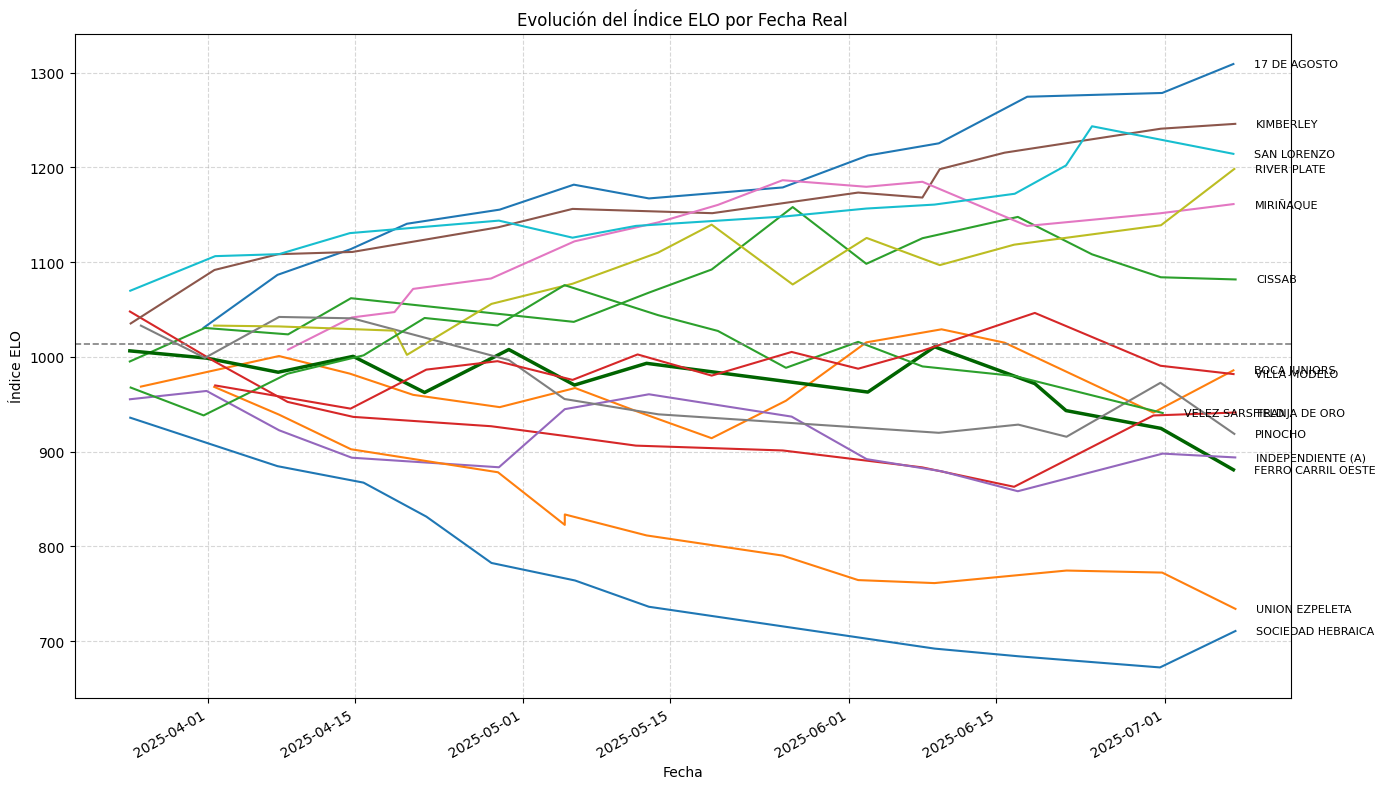

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Asegurarnos que sea copia y convertir fecha técnica
df_plot = df_elo_evolucion.copy()
df_plot["Fecha Técnica"] = pd.to_datetime(df_plot["Fecha Técnica"])

# Calcular promedio final del índice ELO de todos los equipos
df_ultimo_indice = df_plot.sort_values("Fecha Técnica").groupby("Equipo").last().reset_index()
promedio_final = df_ultimo_indice["Indice"].mean()

# Crear figura
plt.figure(figsize=(14, 8))

# Graficar cada equipo
for equipo in df_plot["Equipo"].unique():
    df_equipo = df_plot[df_plot["Equipo"] == equipo].sort_values("Fecha Técnica")
    if equipo == "FERRO CARRIL OESTE":
        plt.plot(df_equipo["Fecha Técnica"], df_equipo["Indice"], label=equipo, linewidth=2.5, color="darkgreen")
    else:
        plt.plot(df_equipo["Fecha Técnica"], df_equipo["Indice"], label=equipo)

    # Etiqueta final separada
    x = df_equipo["Fecha Técnica"].iloc[-1]
    y = df_equipo["Indice"].iloc[-1]
    plt.text(x + pd.Timedelta(days=2), y, equipo, fontsize=8, va='center')

# Línea punteada de promedio
plt.axhline(promedio_final, color='gray', linestyle='--', linewidth=1.2, label='Promedio General')

# Estética
plt.title("Evolución del Índice ELO por Fecha Real")
plt.xlabel("Fecha")
plt.ylabel("Índice ELO")
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()


In [10]:
import numpy as np
import pandas as pd

# ✅ Asegurar formato de fechas
df_resultados["Fecha Técnica"] = pd.to_datetime(df_resultados["Fecha Técnica"])
df_fixture["Fecha Técnica"] = pd.to_datetime(df_fixture["Fecha Técnica"])

# ✅ Funciones auxiliares
def resumen_goles(df, equipo, condicion):
    if condicion == "Local":
        partidos = df[df["Equipo Local"] == equipo]
        gf = partidos["Goles Local"].sum()
        gc = partidos["Goles Visitante"].sum()
    else:
        partidos = df[df["Equipo Visitante"] == equipo]
        gf = partidos["Goles Visitante"].sum()
        gc = partidos["Goles Local"].sum()
    pj = len(partidos)
    return gf, gc, pj

def goles_ponderados(df, equipo, condicion, peso=0.65):
    # Condición actual
    gf_c, gc_c, pj_c = resumen_goles(df, equipo, condicion)
    # Totales
    gf_l, gc_l, pj_l = resumen_goles(df, equipo, "Local")
    gf_v, gc_v, pj_v = resumen_goles(df, equipo, "Visitante")
    pj_t = pj_l + pj_v
    gf_t = gf_l + gf_v
    gc_t = gc_l + gc_v

    # Promedios
    gfp_c = gf_c / pj_c if pj_c > 0 else 0
    gcp_c = gc_c / pj_c if pj_c > 0 else 0
    gfp_t = gf_t / pj_t if pj_t > 0 else 0
    gcp_t = gc_t / pj_t if pj_t > 0 else 0

    # Ponderación combinada
    gfp = peso * gfp_c + (1 - peso) * gfp_t
    gcp = peso * gcp_c + (1 - peso) * gcp_t

    return gfp, gcp

# 🔁 Simulación histórica + próximo partido
ferro = "FERRO CARRIL OESTE"
sim = 15000

# Partidos jugados por Ferro
partidos_ferro = df_resultados[
    (df_resultados["Equipo Local"] == ferro) |
    (df_resultados["Equipo Visitante"] == ferro)
].sort_values("Fecha Técnica")

# Próximo partido
ultima_fecha = partidos_ferro["Fecha Técnica"].max()
proximo = df_fixture[
    ((df_fixture["Equipo Local"] == ferro) | (df_fixture["Equipo Visitante"] == ferro)) &
    (df_fixture["Fecha Técnica"] > ultima_fecha)
].sort_values("Fecha Técnica").head(1)

# Unimos resultados + fixture futuro
partidos_ferro = pd.concat([partidos_ferro, proximo], ignore_index=True)

resultados_finales = []

for _, row in partidos_ferro.iterrows():
    fecha = row["Fecha Técnica"]
    jornada = row.get("Fecha", None)
    local = row["Equipo Local"]
    visitante = row["Equipo Visitante"]
    condicion = "Local" if local == ferro else "Visitante"
    rival = visitante if condicion == "Local" else local

    # Filtrar data histórica hasta ese partido
    df_res_hasta = df_resultados[df_resultados["Fecha Técnica"] < fecha]
    df_elo_hasta = df_elo_evolucion[df_elo_evolucion["Fecha Técnica"] < fecha]

    # Índices ELO
    idx_ferro = df_elo_hasta[df_elo_hasta["Equipo"] == ferro]["Indice"].iloc[-1] if not df_elo_hasta[df_elo_hasta["Equipo"] == ferro].empty else 1000
    idx_rival = df_elo_hasta[df_elo_hasta["Equipo"] == rival]["Indice"].iloc[-1] if not df_elo_hasta[df_elo_hasta["Equipo"] == rival].empty else 1000

    bonus = 100 if condicion == "Local" else 0
    prob_ferro = 1 / (1 + 10 ** ((idx_rival - idx_ferro + bonus) / 400))
    prob_rival = 1 - prob_ferro

    # Goles esperados (ajustados)
    gf_f, gc_f = goles_ponderados(df_res_hasta, ferro, condicion)
    gf_r, gc_r = goles_ponderados(df_res_hasta, rival, "Local" if condicion == "Visitante" else "Visitante")

    goles_esp_ferro = max(0, round((gf_f + gc_r) / 2, 2))
    goles_esp_rival = max(0, round((gf_r + gc_f) / 2, 2))

    # Simulación Monte Carlo
    sim_f = np.random.poisson(goles_esp_ferro, sim)
    sim_r = np.random.poisson(goles_esp_rival, sim)
    outcomes = sim_f - sim_r
    ganado = np.mean(outcomes > 0)
    empatado = np.mean(outcomes == 0)
    perdido = np.mean(outcomes < 0)
    resultado_probable = f"{np.bincount(sim_f).argmax()} - {np.bincount(sim_r).argmax()}"

    resultados_finales.append({
        "Fecha Técnica": fecha,
        "Jornada": jornada,
        "Rival": rival,
        "Condición": condicion,
        "Indice Ferro": round(idx_ferro, 2),
        "Indice Rival": round(idx_rival, 2),
        "Prob Ferro (ELO)": round(prob_ferro, 3),
        "Prob Rival (ELO)": round(prob_rival, 3),
        "Goles Esperados Ferro": goles_esp_ferro,
        "Goles Esperados Rival": goles_esp_rival,
        "Monte Carlo - Ganar": round(ganado, 3),
        "Monte Carlo - Empatar": round(empatado, 3),
        "Monte Carlo - Perder": round(perdido, 3),
        "Resultado Más Probable": resultado_probable
    })

# 📊 Resultado final
df_prediccion_completa = pd.DataFrame(resultados_finales)
df_prediccion_completa


/tmp/ipython-input-2621838817.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados["Fecha Técnica"] = pd.to_datetime(df_resultados["Fecha Técnica"])
/tmp/ipython-input-2621838817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fixture["Fecha Técnica"] = pd.to_datetime(df_fixture["Fecha Técnica"])


,Fecha Técnica,Jornada,Rival,Condición,Indice Ferro,Indice Rival,Prob Ferro (ELO),Prob Rival (ELO),Goles Esperados Ferro,Goles Esperados Rival,Monte Carlo - Ganar,Monte Carlo - Empatar,Monte Carlo - Perder,Resultado Más Probable
0,2025-03-24 14:23:16.833000+00:00,Fecha 1,CISSAB,Local,1000.00,1000.00,0.360,0.640,0.00,0.00,0.000,1.000,0.000,0 - 0
1,2025-03-31 21:35:51.650000+00:00,Fecha 2,INDEPENDIENTE (A),Visitante,1006.27,955.18,0.573,0.427,0.87,0.35,0.464,0.394,0.141,0 - 0
2,2025-04-07 17:01:28.290000+00:00,Fecha 3,KIMBERLEY,Local,998.61,1091.63,0.248,0.752,1.41,3.82,0.098,0.105,0.797,1 - 3
3,2025-04-14 20:05:50.532000+00:00,Fecha 4,FRANJA DE ORO,Visitante,983.72,952.41,0.545,0.455,1.29,2.21,0.211,0.201,0.588,1 - 2
4,2025-04-21 15:04:47.349000+00:00,Fecha 5,VELEZ SARSFIELD,Visitante,1000.49,1001.51,0.499,0.501,2.49,1.84,0.527,0.194,0.279,2 - 1
5,2025-04-29 15:16:48.244000+00:00,Fecha 6,PINOCHO,Local,962.35,1040.60,0.264,0.736,1.65,2.05,0.315,0.207,0.478,1 - 2
6,2025-05-05 21:04:41.007000+00:00,Fecha 7,MIRIÑAQUE,Visitante,1007.68,1082.66,0.394,0.606,1.90,2.45,0.307,0.188,0.505,1 - 2
7,2025-05-12 17:36:34.872000+00:00,Fecha 8,UNION EZPELETA,Local,970.18,833.62,0.552,0.448,2.88,1.58,0.642,0.160,0.198,2 - 1
8,2025-06-02 18:33:11.388000+00:00,Fecha 11,17 DE AGOSTO,Visitante,993.12,1178.75,0.256,0.744,1.67,3.05,0.184,0.158,0.658,1 - 3
9,2025-06-09 03:01:14.227000+00:00,Fecha 12,SOCIEDAD HEBRAICA,Local,962.78,736.19,0.675,0.325,4.28,1.12,0.883,0.073,0.044,4 - 1


In [11]:
import pandas as pd

# Usamos df_resultados y df_elo_evolucion ya procesados

# Inicializamos lista para guardar la comparación fecha por fecha
comparacion_fecha_a_fecha = []

ferro = "FERRO CARRIL OESTE"
partidos_ferro = df_resultados[
    (df_resultados["Equipo Local"] == ferro) | (df_resultados["Equipo Visitante"] == ferro)
].sort_values("Fecha Técnica")

# Funciones para estadísticas
def estadisticas_equipo(df, equipo, condicion):
    if condicion == "Local":
        partidos = df[df["Equipo Local"] == equipo]
        gf = partidos["Goles Local"]
        gc = partidos["Goles Visitante"]
    else:
        partidos = df[df["Equipo Visitante"] == equipo]
        gf = partidos["Goles Visitante"]
        gc = partidos["Goles Local"]

    pj = len(partidos)
    prom_gf = gf.mean() if pj > 0 else 0
    prom_gc = gc.mean() if pj > 0 else 0
    vallas_invictas = (gc == 0).sum()
    marcaron = (gf > 0).sum()
    return pj, round(prom_gf, 2), round(prom_gc, 2), vallas_invictas, marcaron

# Procesar partido a partido
for i, row in partidos_ferro.iterrows():
    fecha = row["Fecha Técnica"]
    jornada = row["Fecha"]
    local = row["Equipo Local"]
    visitante = row["Equipo Visitante"]
    condicion = "Local" if local == ferro else "Visitante"
    rival = visitante if condicion == "Local" else local
    condicion_rival = "Visitante" if condicion == "Local" else "Local"

    # Resultados hasta esa fecha
    df_hasta = df_resultados[df_resultados["Fecha Técnica"] < fecha]

    # Estadísticas generales y por condición
    _, gf_f_total, gc_f_total, vi_f_total, marcaron_f_total = estadisticas_equipo(df_hasta, ferro, "Local")
    _, gf_f_cond, gc_f_cond, vi_f_cond, marcaron_f_cond = estadisticas_equipo(df_hasta, ferro, condicion)

    _, gf_r_total, gc_r_total, vi_r_total, marcaron_r_total = estadisticas_equipo(df_hasta, rival, "Local")
    _, gf_r_cond, gc_r_cond, vi_r_cond, marcaron_r_cond = estadisticas_equipo(df_hasta, rival, condicion_rival)

    comparacion_fecha_a_fecha.append({
        "Fecha Técnica": fecha,
        "Jornada": jornada,
        "Rival": rival,
        "Condición": condicion,
        "GF Ferro (Total)": gf_f_total,
        "GC Ferro (Total)": gc_f_total,
        "GF Ferro (Condición)": gf_f_cond,
        "GC Ferro (Condición)": gc_f_cond,
        "VI Ferro": vi_f_total,
        "GF Rival (Total)": gf_r_total,
        "GC Rival (Total)": gc_r_total,
        "GF Rival (Condición)": gf_r_cond,
        "GC Rival (Condición)": gc_r_cond,
        "VI Rival": vi_r_total,
        "Ferro Marcó Gol": marcaron_f_total,
        "Rival Marcó Gol": marcaron_r_total
    })

df_comparacion = pd.DataFrame(comparacion_fecha_a_fecha)
df_comparacion


,Fecha Técnica,Jornada,Rival,Condición,GF Ferro (Total),GC Ferro (Total),GF Ferro (Condición),GC Ferro (Condición),VI Ferro,GF Rival (Total),GC Rival (Total),GF Rival (Condición),GC Rival (Condición),VI Rival,Ferro Marcó Gol,Rival Marcó Gol
0,2025-03-24 14:23:16.833000+00:00,Fecha 1,CISSAB,Local,0.00,0.0,0.00,0.00,0,0.00,0.00,0.00,0.00,0,0,0
1,2025-03-31 21:35:51.650000+00:00,Fecha 2,INDEPENDIENTE (A),Visitante,2.00,2.0,0.00,0.00,0,0.00,0.00,0.00,0.00,0,1,0
2,2025-04-07 17:01:28.290000+00:00,Fecha 3,KIMBERLEY,Local,2.00,2.0,2.00,2.00,0,4.00,0.00,6.00,1.00,1,1,1
3,2025-04-14 20:05:50.532000+00:00,Fecha 4,FRANJA DE ORO,Visitante,1.00,2.0,2.00,2.00,0,3.00,0.00,3.00,0.00,1,1,1
4,2025-04-21 15:04:47.349000+00:00,Fecha 5,VELEZ SARSFIELD,Visitante,1.00,2.0,2.00,1.50,0,2.00,3.50,2.00,3.50,0,1,2
5,2025-04-29 15:16:48.244000+00:00,Fecha 6,PINOCHO,Local,1.00,2.0,1.00,2.00,0,4.50,2.50,1.50,2.00,0,1,2
6,2025-05-05 21:04:41.007000+00:00,Fecha 7,MIRIÑAQUE,Visitante,2.00,2.0,2.00,2.33,0,2.00,2.00,2.00,2.00,0,2,2
7,2025-05-12 17:36:34.872000+00:00,Fecha 8,UNION EZPELETA,Local,2.00,2.0,2.00,2.00,0,1.00,6.00,1.00,3.33,0,2,1
8,2025-06-02 18:33:11.388000+00:00,Fecha 11,17 DE AGOSTO,Visitante,2.25,2.0,1.75,2.75,0,3.20,1.40,3.20,1.40,1,3,5
9,2025-06-09 03:01:14.227000+00:00,Fecha 12,SOCIEDAD HEBRAICA,Local,2.25,2.0,2.25,2.00,0,0.33,6.33,0.00,6.50,0,3,1


In [12]:
# Verificar la última fecha jugada por Ferro
ultima_fecha = df_resultados[
    (df_resultados["Equipo Local"] == "FERRO CARRIL OESTE") |
    (df_resultados["Equipo Visitante"] == "FERRO CARRIL OESTE")
]["Fecha Técnica"].max()

print(f"🕒 Última fecha jugada por Ferro: {ultima_fecha}")

# Buscar próximos partidos después de esa fecha
proximo_partido = df_fixture[
    ((df_fixture["Equipo Local"] == "FERRO CARRIL OESTE") |
     (df_fixture["Equipo Visitante"] == "FERRO CARRIL OESTE")) &
    (df_fixture["Fecha Técnica"] > ultima_fecha)
].sort_values("Fecha Técnica")

# Mostrar el resultado
if proximo_partido.empty:
    print("⚠️ No hay un próximo partido disponible para Ferro.")
else:
    display(proximo_partido.head(1))


🕒 Última fecha jugada por Ferro: 2025-07-07 12:45:01.432000+00:00
⚠️ No hay un próximo partido disponible para Ferro.


In [13]:
# Filtrar partidos de Ferro en el fixture
fixture_ferro = df_fixture[
    (df_fixture["Equipo Local"] == "FERRO CARRIL OESTE") |
    (df_fixture["Equipo Visitante"] == "FERRO CARRIL OESTE")
][["Fecha Técnica", "Equipo Local", "Equipo Visitante", "Fecha"]]

display(fixture_ferro.sort_values("Fecha Técnica"))


,Fecha Técnica,Equipo Local,Equipo Visitante,Fecha


In [14]:
!pip install xlsxwriter

# Eliminar zona horaria de las columnas de fecha
def limpiar_fechas(df, columnas):
    for col in columnas:
        if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].dt.tz_localize(None)
    return df

# Ruta destino en Google Drive
archivo_final = "/content/drive/MyDrive/Sport Data Campus/TFM/Ferro_Previas_PowerBI_Final.xlsx"

# Preparar exportación
with pd.ExcelWriter(archivo_final, engine="xlsxwriter") as writer:
    if 'df_resultados' in globals():
        df_resultados = limpiar_fechas(df_resultados, ["Fecha Técnica"])
        df_resultados.to_excel(writer, sheet_name="Resultados", index=False)

    if 'df_fixture' in globals():
        df_fixture = limpiar_fechas(df_fixture, ["Fecha Técnica"])
        df_fixture.to_excel(writer, sheet_name="Fixture", index=False)

    if 'df_elo_evolucion' in globals():
        df_elo_evolucion = limpiar_fechas(df_elo_evolucion, ["Fecha Técnica"])
        df_elo_evolucion.to_excel(writer, sheet_name="ELO", index=False)

    if 'df_prediccion_completa' in globals():
        df_prediccion_completa = limpiar_fechas(df_prediccion_completa, ["Fecha Técnica"])
        df_prediccion_completa.to_excel(writer, sheet_name="Predicciones", index=False)

    if 'df_comparacion' in globals():
        df_comparacion = limpiar_fechas(df_comparacion, ["Fecha Técnica"])
        df_comparacion.to_excel(writer, sheet_name="Comparacion", index=False)

    if 'df_tabla' in globals():
        df_tabla.to_excel(writer, sheet_name="Tabla_Posiciones", index=False)

    if 'df_tabla_evolutiva' in globals():
        df_tabla_evolutiva = limpiar_fechas(df_tabla_evolutiva, ["Fecha Técnica"])
        df_tabla_evolutiva.to_excel(writer, sheet_name="Tabla_Evolutiva", index=False)

    if 'ultimo_elo_ordenado' in globals():
        ultimo_elo_ordenado = limpiar_fechas(ultimo_elo_ordenado, ["Fecha Técnica"])
        ultimo_elo_ordenado.to_excel(writer, sheet_name="Ultimo_ELO", index=False)

    if 'tabla_tendencia' in globals():
        tabla_tendencia = limpiar_fechas(tabla_tendencia, ["Fecha Técnica"])
        tabla_tendencia.to_excel(writer, sheet_name="Tabla_Tendencia", index=False)

    if 'tabla_ranking' in globals():
        tabla_ranking = limpiar_fechas(tabla_ranking, ["Fecha Técnica"])
        tabla_ranking.to_excel(writer, sheet_name="Tabla_Ranking", index=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 4.4 MB/s eta 0:00:00


/tmp/ipython-input-510002876.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].dt.tz_localize(None)
